In [1]:
import pandas as pd
import os
__file__ = os.getcwd()
dirname = os.path.dirname(__file__)
input_file = os.path.join(dirname, 'data\\dogodki100samoglavne_strippedOnlySlov.csv')
df = pd.read_csv(input_file, header = 0)
df.head()

,naziv,opis,datum_od,stevilo,sifra_prizorisca,kategorije_sifre,kategorije_nazivi,kategorije_sifre_new,kategorije_nazivi_new
0,"Fem. seminar: Feminizem, nacionalizem in družb...",predavanje predstaviti študija sara farris nas...,2020-02-04 19:30:00,300,1.486186e+15,"16,32","Kid Friendly,Causes",32,Causes
1,BALKAN x TRAP Night / 21.2.2020 / Max Klub,februar znova vračati max klub nadaljevati del...,2020-02-21 22:00:00,501,2.346167e+14,15,Party,15,Party
2,Medštudijski kongres: (R)evolucija bakterij,bakterija povzročiti evropski unija smrt leto ...,2020-03-07 09:00:00,1519,1.104668e+15,5,Other,5,Other
3,Kvatropirci | Hajdoše,začetek leto kvatropirec prvič podajati koncer...,2020-02-28 20:00:00,368,1.871309e+14,"2,6,16,55","Music,Concert,Kid Friendly,Pop music",2,Music
4,Lions Obarjada 2020,vabiti velik humanitaren družaben karnevalski ...,2020-02-15 09:00:00,336,4.763924e+14,"4,5,16,71,158","Volunteering,Other,Kid Friendly,Limited to peo...",5,Other


In [2]:
df = df[pd.notnull(df['opis'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3026 entries, 0 to 3025
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   naziv                  3026 non-null   object 
 1   opis                   3026 non-null   object 
 2   datum_od               3026 non-null   object 
 3   stevilo                3026 non-null   int64  
 4   sifra_prizorisca       3022 non-null   float64
 5   kategorije_sifre       3026 non-null   object 
 6   kategorije_nazivi      3026 non-null   object 
 7   kategorije_sifre_new   3026 non-null   int64  
 8   kategorije_nazivi_new  3026 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 236.4+ KB


In [4]:
col = ['kategorije_nazivi_new', 'opis']
df = df[col]

In [5]:
df.columns

Index(['kategorije_nazivi_new', 'opis'], dtype='object')

In [6]:
df.columns = ['kategorije_nazivi_new', 'opis']

In [7]:
df['category_id'] = df['kategorije_nazivi_new'].factorize()[0]
from io import StringIO
category_id_df = df[['kategorije_nazivi_new', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'kategorije_nazivi_new']].values)

In [8]:
df.head()

,kategorije_nazivi_new,opis,category_id
0,Causes,predavanje predstaviti študija sara farris nas...,0
1,Party,februar znova vračati max klub nadaljevati del...,1
2,Other,bakterija povzročiti evropski unija smrt leto ...,2
3,Music,začetek leto kvatropirec prvič podajati koncer...,3
4,Other,vabiti velik humanitaren družaben karnevalski ...,2


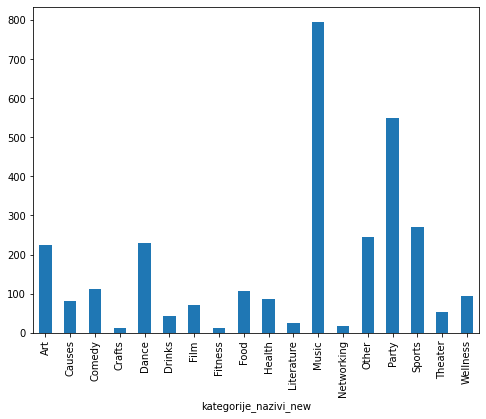

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('kategorije_nazivi_new').opis.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, ngram_range=(1, 2), norm='l2')

features = tfidf.fit_transform(df.opis).toarray()
labels = df.category_id
features.shape

(3026, 12187)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for kategorije_nazivi_new, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(kategorije_nazivi_new))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Art':
  . Most correlated unigrams:
       . razstava
       . galerija
  . Most correlated bigrams:
       . likoven umetnost
       . sodoben umetnost
# 'Causes':
  . Most correlated unigrams:
       . ohranjen
       . oblačilo
  . Most correlated bigrams:
       . kos oblačilo
       . moden dodatek
# 'Comedy':
  . Most correlated unigrams:
       . stand
       . komik
  . Most correlated bigrams:
       . stand komedija
       . rok bohinc
# 'Crafts':
  . Most correlated unigrams:
       . pogreti
       . buča
  . Most correlated bigrams:
       . domač dobrota
       . domač obrt
# 'Dance':
  . Most correlated unigrams:
       . bachati
       . plesen
  . Most correlated bigrams:
       . plesen večer
       . lost founda
# 'Drinks':
  . Most correlated unigrams:
       . vinski
       . vino
  . Most correlated bigrams:
       . vipavski dolina
       . slovenski ister
# 'Film':
  . Most correlated unigrams:
       . filmski
       . film
  . Most correlated bigrams:
     

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['opis'], df['kategorije_nazivi_new'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)



In [13]:
predictString = "čas lifa prihajati zvezda vedeti vedeti lifa vroč vedeti super žurer hoditi dom lifa prihajati fantastičen ogrevanje poskrbeti sandy deej vstopnina predprodaja eventimpoštapetrola predprodaja vrata dan dogodek starosten omejitev aga limiti infa vip rezervacija lifediskoteka gmailc lifeklubdomzati"

print(clf.predict(count_vect.transform([predictString])))

df[df['opis'] == predictString]

['Party']


,kategorije_nazivi_new,opis,category_id


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

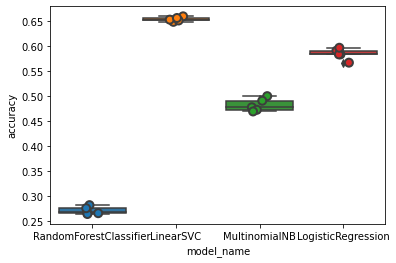

In [15]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.653670
LogisticRegression        0.584268
MultinomialNB             0.482149
RandomForestClassifier    0.271312
Name: accuracy, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

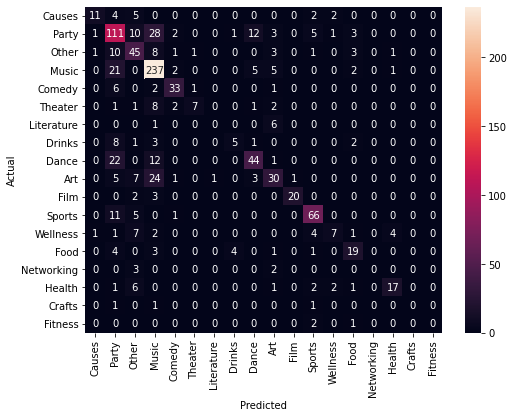

In [18]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.kategorije_nazivi_new.values, yticklabels=category_id_df.kategorije_nazivi_new.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['kategorije_nazivi_new', 'opis']])
      print('')

'Other' predicted as 'Party' : 10 examples.


,kategorije_nazivi_new,opis
906,Other,alfa klub slovenija fiat klub slovenija skupaj...
2410,Other,program dan petek sprostitven večer gong gozde...
704,Other,kdfd korant spuhelj vabiti sejem razstava kora...
599,Other,lepo vabljen vabljen praznovanje obletnica štu...
1087,Other,vrata tradicionalen pomorski krst star nepreki...
638,Other,dogodek jesenski čist vabiti najbolj noro leto...
2266,Other,neandertalec sodoben tehnologija uspeti izdela...
991,Other,želja prihajajoč praznik kvaliteten božičen fo...
4,Other,vabiti velik humanitaren družaben karnevalski ...
2285,Other,upihniti navdihujoč svečka pomagati uresničiti...



'Music' predicted as 'Party' : 21 examples.


,kategorije_nazivi_new,opis
501,Music,drag študent študent duša obljubljen pripravit...
117,Music,lajf zabava lajf prijatelj lajf kul dogodek va...
2485,Music,žirfest dober doslej žirfest predstavljati vel...
2784,Music,fašenka markovci prihajati velik praznik marko...
2342,Music,kryptonight jump frenzy maribor kje dvorana gu...
1537,Music,novembrski žur vrata videti zabava soba room z...
2852,Music,attention velenje izjemno uspešen dogodek mari...
1118,Music,ljubljanica reka močen tih vijugati buča nemo ...
2466,Music,poskočen rezidenca družba poskočen muzikant pe...
1661,Music,prihajati noč svet ameriški vzor haloween kup ...



'Comedy' predicted as 'Party' : 6 examples.


,kategorije_nazivi_new,opis
2518,Comedy,joška noč čarovnica ponovno vračati kjer pripr...
1396,Comedy,krajeven skupnost vogrski kulturen turističen ...
1418,Comedy,raven prihajati komik kolektiv ceh smeh poskrb...
1525,Comedy,kokokomičen četrtek bližati izpiten obdobje pr...
2028,Comedy,predstava srečen konec država štajerski republ...
2833,Comedy,kdaj pusten rajanje stolp pungert pusten torek...



'Drinks' predicted as 'Party' : 8 examples.


,kategorije_nazivi_new,opis
531,Drinks,martinovanje vas gotovlje otvoritev martinovan...
1014,Drinks,zbrati ura klet svet kralj odpraviti obisk kle...
2428,Drinks,vino voda klub ptujski študent letos leto orga...
572,Drinks,knežji degustacija gin sodelovanje selection k...
2106,Drinks,vedeti ljudski rek praviti martinovo jesenski ...
597,Drinks,degustacija viski sodelovanje selection kdaj s...
2938,Drinks,vabljen arena nepozabno zabava tekmovalec kmet...
1458,Drinks,leto pripravljati dogodek kjer družba kolektiv...



'Dance' predicted as 'Party' : 22 examples.


,kategorije_nazivi_new,opis
453,Dance,točno leto minevati začeti zgodba paracosmi lo...
2014,Dance,konec februar zavetje swenak vračati idr tokra...
2877,Dance,drag prijatelj vračati dobro poznan mojster dj...
570,Dance,dober bolj začinjen kačišnec vljudno vabljen t...
1122,Dance,vabljen tradicionalen pust party pub sinji gor...
1098,Dance,prihajati oktoberfešta okrepčevalnica matija p...
1256,Dance,noč lahko izkušnja dvigniti las pokonci lahko ...
1841,Dance,nagraden igra top koncert skupina učiteljica p...
2584,Dance,urban grooves pekarna gustafa zadnjič letos do...
2566,Dance,velik veselica šotor letnica pgd tepanje hkrat...



'Sports' predicted as 'Party' : 11 examples.


,kategorije_nazivi_new,opis
2707,Sports,grajski gospod vabiti srednjeveški dan lemberg...
1239,Sports,zgled kolega ata sabak odločiti prikrajšan otr...
1109,Sports,balvanija praznovati rojsten dan koledar opomn...
1288,Sports,približevati zima vesel december drsališče med...
2230,Sports,marija jeglič uspešen slovenski leto dogodivšč...
1521,Sports,dišati sneg nikakor misliti bel strmina potem ...
2657,Sports,prvič revers lapa minuta obrniti smer vožnja z...
619,Sports,skupaj kurs klub študent ruša selnica lovrenc ...
132,Sports,praviti lep enkrat konec dogodek gremovhrib ve...
2240,Sports,drag zavedati zmagati pomagati dogodek prestav...



'Party' predicted as 'Other' : 10 examples.


,kategorije_nazivi_new,opis
2640,Party,letošnji september občina ilirski bistrica sod...
2586,Party,vabiti dan odprt vrata četrtek ura sedež podje...
2064,Party,kolumbija venezuela zadnji država potovanje ju...
641,Party,meddruštven razstava mali pasemski žival prire...
2689,Party,turističen društvo star letos prirejati dan og...
245,Party,zavod turizem cerklje občina cerklje sodelovan...
402,Party,sodelovanje vitez najemnik celjski grof pripra...
251,Party,poleten dogajanje letos poskrbeti tradicionale...
1260,Party,četrtek vljudno vabljen noč čarovnica potekati...
2376,Party,družinski dan prihajati brezica sodelovanje ho...



'Art' predicted as 'Other' : 7 examples.


,kategorije_nazivi_new,opis
1599,Art,mednaroden dan turističen vodnik vabiti ogled ...
2426,Art,zsolt miklósvölgy márió nemes technologia unda...
2815,Art,govorica nem obraz obraz govorica težko razume...
459,Art,mlad danes narediti youtuber influencer zdravn...
1648,Art,jan dular družina ustvariti afrik najbolj srče...
752,Art,obveščati predavanje ogorevc razprodan vstopni...
1255,Art,luč aktualen situacija obvladovati desen lev p...



'Wellness' predicted as 'Other' : 7 examples.


,kategorije_nazivi_new,opis
1724,Wellness,mesto seminar zaseden inspirativen seminar otr...
104,Wellness,maribor prihajati lep kraj pripraviti personal...
545,Wellness,tradicionalen adventen razstava letos velik sp...
2312,Wellness,matej delakord govornik maraton pozitiven psih...
997,Wellness,novost letošnji maraton pozitiven psihologija ...
1161,Wellness,marjan korotati serepethin lepo vabljen predav...
1217,Wellness,celodneven druženje priznan poznavalec pot dob...



'Health' predicted as 'Other' : 6 examples.


,kategorije_nazivi_new,opis
1902,Health,srečanje ospredje predstavitev različen oblika...
1086,Health,predstavitev sodoben človek preveč živeti idej...
1450,Health,sekcija študent združenje fizioterapev sloveni...
2302,Health,reden profesor dejan dinevski medicinski fakul...
2497,Health,vabljen strokovno delavnica psihedelika terapi...
2937,Health,kdaj sobota november urnik ura kje zaloški ces...



'Party' predicted as 'Music' : 28 examples.


,kategorije_nazivi_new,opis
2216,Party,english below nov leto tukaj jesenski piknik m...
2192,Party,edin vabljen pot kjer dvorana leden sonce ring...
385,Party,velik dober zlitje slovenski ljubezenski pesem...
2718,Party,vabiti december preživeti družba pripravljati ...
1682,Party,bang elements hip hop koncert smok mardeljan s...
615,Party,ansambel brlog praznovati obletnica obetati pe...
674,Party,balkan mania cren mišić pergola club velik bal...
766,Party,star grad celj dežela celjski vabiti vrvež trš...
1503,Party,vročica poleten soboten noč odličen glasba dru...
2734,Party,nepozaben lanski praznovanje letos praznovati ...



'Other' predicted as 'Music' : 8 examples.


,kategorije_nazivi_new,opis
1850,Other,slovenija miting mali letalstvo lesce velik mi...
2884,Other,prostovoljno gasilski društvo škofji lok vljud...
2828,Other,ura zasvetiti svetlica javen zavod ceza občina...
296,Other,slišati krisov zgodba takoj stopiti akcija pri...
628,Other,pridružiti tradicionalen sejem prazničen dobro...
2048,Other,leto praznovati leto doma krajan negovan nemec...
1246,Other,predavati nina smola hoja francoskošpanski pot...
2231,Other,spoštovan tovarišica tovariš drag prijateljica...



'Theater' predicted as 'Music' : 8 examples.


,kategorije_nazivi_new,opis
2501,Theater,bohuslav martinů ženitev komičen opera dejanje...
910,Theater,zamuditi pravljičen muzikal imeti sedaj nov pr...
962,Theater,postati heroj pripeljati beseda vedeti bel het...
135,Theater,frivolus festival uličen umetnik dan očarati o...
2201,Theater,muzikal mamma mia ogledati videti enkrat zadnj...
2118,Theater,zapornik včasih življenje prinesti lep lahko z...
134,Theater,frivolus festival uličen umetnik dan očarati o...
1390,Theater,članica skupina igralka gledališče dakh kijev ...



'Dance' predicted as 'Music' : 12 examples.


,kategorije_nazivi_new,opis
295,Dance,baleten predstava zvezda piran sklop poleten f...
1811,Dance,iti was all drea biggie smalls tokraten izdaja...
1758,Dance,vesel december zato kgti vabiti petek marco po...
655,Dance,vesel december diskoteka marco polo koncert sk...
2903,Dance,sobota februar espacia flamenca tablao skupina...
1538,Dance,program pregled prenovljen prostor lokev razst...
927,Dance,friends jack pripravljati poseben event amadeu...
2913,Dance,prihajati najbolj vroč terasa krvavec mamba ki...
748,Dance,đungla stric harmonika tromostovje začeti spre...
1923,Dance,otvoritev nov sezona rolanda tora ustanovitelj...



'Art' predicted as 'Music' : 24 examples.


,kategorije_nazivi_new,opis
1273,Art,leto iva dimch koreograf performer vizualen um...
2908,Art,osrednji novomeški prireditev kulturen praznik...
880,Art,jubilejen prireditev pesem vas ime tolminski p...
1491,Art,ditka svet glasba vstopiti majhen deklica oče ...
306,Art,pol kod saba mešan moškoženski veččlanski zase...
723,Art,tradicionalen božičnonovoleten koncert goran b...
1775,Art,simona semenič naslov izhodišče ustvarjalen pr...
909,Art,napovedovati slavnosten večer opernobaleten sp...
2579,Art,samospev balet operen baleten večer naslov lju...
2532,Art,simona semenič naslov izhodišče ustvarjalen pr...



'Party' predicted as 'Dance' : 12 examples.


,kategorije_nazivi_new,opis
2927,Party,vabljen spektakel mademoisell plesen studio le...
1041,Party,zabava evforija tinkara alenka omemba turneja ...
1950,Party,otvoritev sezona just serialka klet ekipa gost...
2406,Party,letos nastopati tequiti petkov pumpa srečelov ...
582,Party,maka iti december remember prihajati zadnji me...
938,Party,lif noreti zadnji dan februar prestopen leto t...
1829,Party,drag gost november dalje pihati svečka torta v...
2494,Party,pridružiti rosat doživetje petek ura terasa my...
425,Party,dogodek potekati gasilski dom vrzdenec namenje...
518,Party,ica cold vzhajajoč zvezda regijski trap scena ...



'Literature' predicted as 'Art' : 6 examples.


,kategorije_nazivi_new,opis
302,Literature,počastitev knjižnica sevnica vabljen osrednji ...
722,Literature,vljudno vabljenea predstavitev pesniški prvenk...
961,Literature,povezovati bernarda žarna glasba balladera klu...
1359,Literature,knjiga spregovorileo katji čičigoj tanje rener...
2170,Literature,razstava velenje prikazovati urbanističen zasn...
2931,Literature,maček findus praznovanje rojsten dan znati pre...


In [20]:
model.fit(features, labels)

LinearSVC()

In [21]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Art':
  . Top unigrams:
       . galerija
       . umetnost
  . Top bigrams:
       . vabljen koncert
       . karta dobiti
# 'Causes':
  . Top unigrams:
       . oblačilo
       . zahtevati
  . Top bigrams:
       . okrogel miza
       . spoštovan ljubitelj
# 'Comedy':
  . Top unigrams:
       . stand
       . komik
  . Top bigrams:
       . tadej toš
       . stand večer
# 'Crafts':
  . Top unigrams:
       . buča
       . izdelek
  . Top bigrams:
       . domač dobrota
       . domač obrt
# 'Dance':
  . Top unigrams:
       . plesen
       . ples
  . Top bigrams:
       . plesen večer
       . glasba čas
# 'Drinks':
  . Top unigrams:
       . vino
       . degustacija
  . Top bigrams:
       . reljati popović
       . slovenski ister
# 'Film':
  . Top unigrams:
       . film
       . filmski
  . Top bigrams:
       . vstopnica prodaja
       . slovenski film
# 'Fitness':
  . Top unigrams:
       . opna
       . fitnes
  . Top bigrams:
       . mednaroden tekmovanje
       . prakt

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['kategorije_nazivi_new'].unique()))

              precision    recall  f1-score   support

      Causes       0.79      0.46      0.58        24
       Party       0.54      0.63      0.58       177
       Other       0.49      0.61      0.54        74
       Music       0.71      0.87      0.78       273
      Comedy       0.79      0.77      0.78        43
     Theater       0.78      0.32      0.45        22
  Literature       0.00      0.00      0.00         7
      Drinks       0.50      0.25      0.33        20
       Dance       0.67      0.56      0.61        79
         Art       0.55      0.42      0.47        72
        Film       0.95      0.80      0.87        25
      Sports       0.79      0.80      0.79        83
    Wellness       0.58      0.26      0.36        27
        Food       0.59      0.59      0.59        32
  Networking       0.00      0.00      0.00         5
      Health       0.74      0.57      0.64        30
      Crafts       0.00      0.00      0.00         3
     Fitness       0.00    

In [24]:

   
from extras.textCleaningNLTK import preprocessText

texts = ["""Če ste zamudili silvestrsko predstavo Jazz ali pa bi si jo radi ogledali še enkrat ... 🤩↙️
Romantično dramo Nejca Gazvode Jazz, ki smo si jo lahko na silvestrovo premierno v živo ogledali na spletu, bomo ponovili tudi v četrtek, 14. januarja, ob 20. uri.
Januarska ponovitev bo posnetek s premiere, 31. decembra, ki si jo boste lahko ogledali na spletni strani tretjioder.si.
E-vstopnice so že v prodaji po ceni 10 eur.
E-vstopnice so že v prodaji na povezavi:
https://tretjioder.si/trgovina/predstava-jazz-14-1/
#jazz2020
Nejc Gazvoda
Jazz
Romantična drama
Krstna uprizoritev
režiser Nejc Gazvoda
igrata Ajda Smrekar in Sebastian Cavazza
Streha razkošne vile, v kateri poteka zabava v maskah. Večer, zvezde, glasba, penina. Na balkonu se srečata moški in ženska. Oba sta oblečena v ptiča. Ona je stara nekaj čez trideset, on je sredi štiridesetih. On je pianist, ki je še ravnokar igral na zabavi. Ona je ... obiskovalka? Natakarica? Zapleteta se v pogovor. Na koncu večera – v katerem bosta drug o drugem nekaj izvedela in stkala krhke vezi poznanstva, kar že spominja na toplo človeško bližino (če je kaj takega v enem večeru sploh mogoče začutiti do popolnega tujca) – se dogovorita, da se bosta na istem balkonu znova srečala ob letu osorej. In tako nadaljnjih pet let. Odnos se bo poglabljal, podatkih o njunih življenjih postopoma razkrivali. Vsako leto v novi maski in brez védenja, kako je drugemu ime, bosta moški in ženska drug drugemu postala pomemben del življenja, dan zabave in srečanja pa datum, ki bo v njunih življenjih nekaj pomenil, četudi bosta ti življenji preostalih 364 dni tekli po svoje ... Katero leto bo zadnje?"""]
textsCleaned = []
for text in texts:
    textsCleaned.append(preprocessText(text))
    
text_features = tfidf.transform(textsCleaned)
predictions = model.predict(text_features)
for text, predicted in zip(textsCleaned, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")



"zamuditi silvestrski predstava jazz ogledati enkrat romantično drama nejec gazvod jazz lahko silvestrovo premierno živo ogledati splet ponoviti četrtek januar ura januarski ponovitev posnetek premiera december lahko ogledati spleten stran tretjioders evstopnica prodaja cena eura evstopnica prodaja povezava nejc gazvoda jazz romantičen drama krsten uprizoritev režiser nejc gazvoda igrati ajda smrekar sebastian cavazza streha razkošen vila potekati zabava maska večer zvezda glasba penina balkon srečati moški ženska oblečen ptič star pianist ravnokar igrati zabava obiskovalka natakarica zaplesti pogovor konec večer izvedeti stkati krhek vez poznanstvo spominjati toplo človeški bližina večer mogoč začutiti popoln tujec dogovoriti balkon znova srečati leto osorej nadaljnji leto odnos poglabljati podatek življenje postopoma razkrivati leto nov maska védenje ime moški ženska postati pomemben del življenje dan zabava srečanje datum življenje pomeniti življenje preostal dan teči leto zadnji"
 